# Coding and Financial Analysis

---

## Pre-requisites

- Create conda env using the following command from the root of this repo: `conda env create -f ./notebooks/multi-agent-systems/pyautogen/conda-env.yaml`.
- Please define the following environment variables in `.env` file:
    - `OPENAI_API_BASE="<ENDPOINT_URL>"`
    - `OPENAI_API_KEY="<API_KEY>"`

## Introduction

In this tutorial, we will:
- explore how to add coding capabilities to agents to generate code snippets for financial analysis.
- execute the generated code snippets to complete financial analysis task.

We will get to build two agent systems where agents collaborate to solve the task at hand while asking for human feedback.

<img src="./images/code-execution.png" alt="Code Execution" style="width: 30%;"/>

## Setup

In [10]:
import warnings
import os
from dotenv import load_dotenv, find_dotenv

warnings.filterwarnings('ignore')
_ = load_dotenv(find_dotenv())

Please find additional info about how to create LLM Configuration [over here](https://microsoft.github.io/autogen/docs/topics/llm_configuration).

In [11]:
llm_config = {
    "model": "gpt-4-turbo",
    "api_type": "azure",
    "base_url": os.environ.get("OPENAI_API_BASE"),
    "api_key": os.environ.get("OPENAI_API_KEY"),
}

## Define a code executor

In [12]:
from autogen.coding import LocalCommandLineCodeExecutor

executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

## Create agents

In [13]:
from autogen import ConversableAgent, AssistantAgent

### Agent with code executor configuration

In [14]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### Agent with code writing capability

In [15]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [16]:
code_writer_agent_system_message = code_writer_agent.system_message
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

## The task!

Ask the two agents to collaborate on a stock analysis task.

In [17]:
import datetime

today = datetime.datetime.now().date()
message = f"Today is {today}. "\
"Create a plot showing stock gain YTD for NVDA and TLSA. "\
"Make sure the code is in markdown code block and save the figure"\
" to a file ytd_stock_gains.png."""

In [22]:
chat_result = code_executor_agent.initiate_chat(
    recipient=code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2024-08-26. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To create the plot showing the Year-To-Date (YTD) stock gains for NVIDIA (NVDA) and Tesla (TSLA), follow these steps:

1. Collect the stock data for NVDA and TSLA from the beginning of the year (2024) to the present day (2024-08-26).
2. Calculate the YTD gains from this data.
3. Plot the data and save the plot to a file named `ytd_stock_gains.png`.

Let's begin by fetching the stock data using the `yfinance` library, which provides historical market data from Yahoo Finance. Execute the following Python code in a Jupyter Notebook or a suitable Python environment:

```python
# filename: plot_stock_gains.py
import yfinance as yf
import matplotlib.pyp

## Let's see the plot!

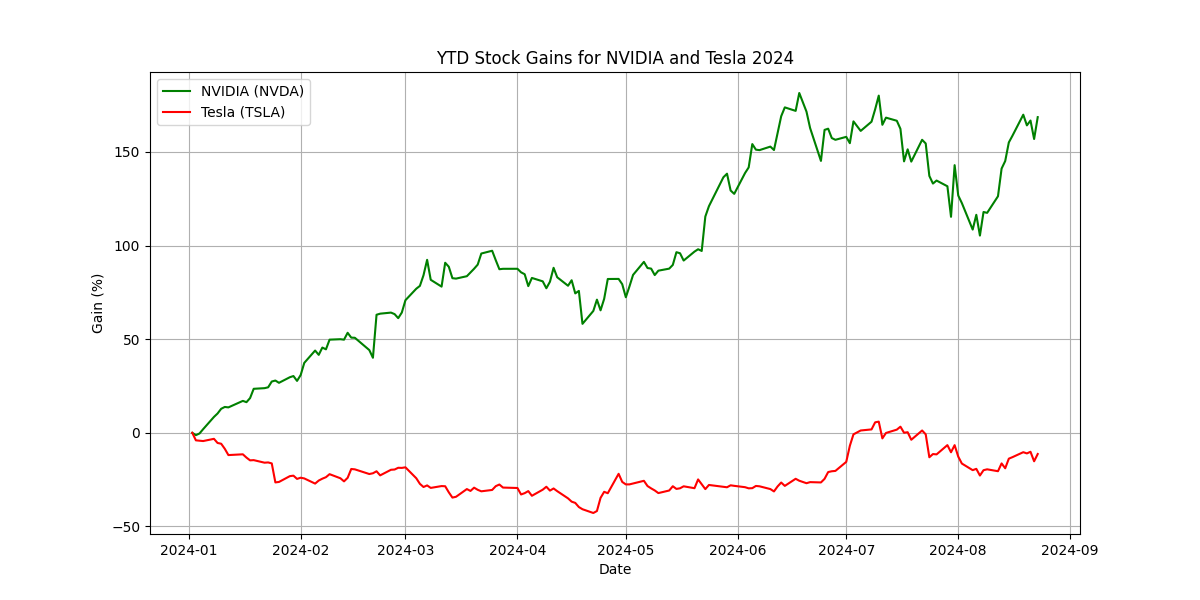

In [23]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))

> Note: The agent will automatically save the code in a .py file and the plot in a .png file.

## User-Defined Functions

Instead of asking LLM to generate the code for downloading stock data and plotting charts each time, you can define functions for these two tasks and have LLM call these functions in the code.

In [24]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format 
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock 
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

In [25]:
def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the 
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

## Create a new executor with the user-defined functions

In [26]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],
)

In [27]:
code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

## Let's update the agents with the new system message

In [28]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [29]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

## Start the same task again!

In [30]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}."
    "Download the stock prices YTD for NVDA and TSLA and create"
    "a plot. Make sure the code is in markdown code block and "
    "save the figure to a file stock_prices_YTD_plot.png.",
)

code_executor_agent (to code_writer_agent):

Today is 2024-08-26.Download the stock prices YTD for NVDA and TSLA and createa plot. Make sure the code is in markdown code block and save the figure to a file stock_prices_YTD_plot.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

First, let's write a Python script to fetch the stock prices for NVIDIA (NVDA) and Tesla (TSLA) from the start of the year to today, and then plot these prices. The output plot will be saved to a file named `stock_prices_YTD_plot.png`.

```python
# filename: fetch_and_plot_stocks.py
from functions import get_stock_prices, plot_stock_prices
import pandas as pd

# Dates for the year-to-date (start of the year to today)
start_date = '2024-01-01'
end_date = '2024-08-26'

# Stock symbols for NVIDIA and Tesla
stock_symbols = ['NVDA', 'TSLA']

# Get the stock prices
stock_prices = get_stock_prices(stock_symbols, start_date, end_date)

# Pl

## Plot the results

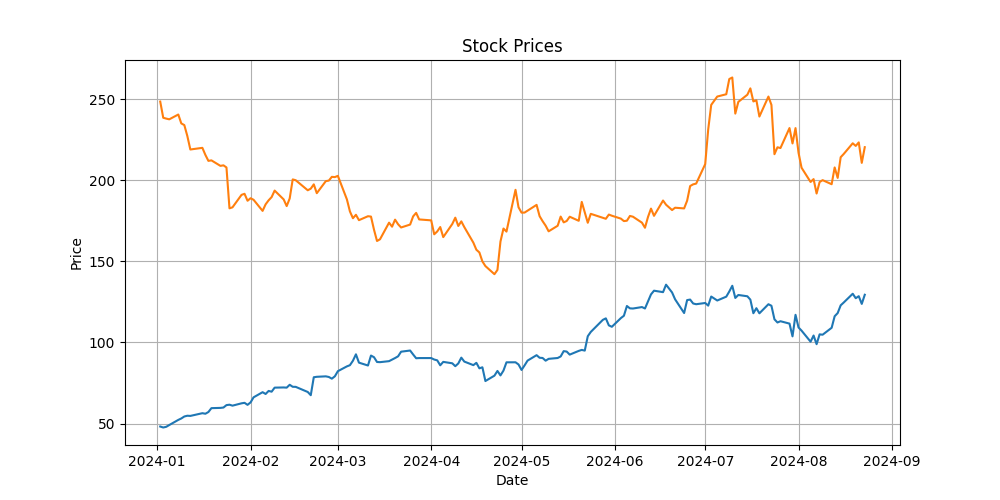

In [31]:
Image(os.path.join("coding", "stock_prices_YTD_plot.png"))